In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import sys
sys.path.append('..')
from student_utils import adjacency_matrix_to_graph, cost_of_solution
from solver_utils import parse_input
from visualize import plot_graph
import collections
import time

from solvers.mst import mst_dfs_solve
from solvers.local_search import local_search_solve, k_shortest_paths

%matplotlib inline

In [ ]:
solvers = {
    'MST+DFS': mst_dfs_solve,
}

In [ ]:
"""
Solve Interface
Input:
    list_of_locations: A list of locations such that node i of the graph corresponds to name at index i of the list
    list_of_homes: A list of homes
    starting_car_location: The name of the starting location for the car
    adjacency_matrix: The adjacency matrix from the input file
Output:
    A list of locations representing the car path
    A dictionary mapping drop-off location to a list of homes of TAs that got off at that particular location
    NOTE: both outputs should be in terms of indices not the names of the locations themselves
"""

## Solver 1: MST + DFS

Idea: similar to the 2x approximation algorithm for MetricTSP, but in this case, we may not be able to remove every duplicate vertex seen (after its first occurence), because the original graph is not necessarily fully connected. Thus, we can only skip vertices when it is possible (i.e. there is an edge to take the shortcut). In this tour, we will drop everyone off at their house. No TA needs to walk.

Graphs that this is bad for:
- Branching graphs (lots of driving back and forth, where walking would be more optimal

Graphs that this is good for:
- Very connected graphs

In [ ]:
from solvers.mst import mst_dfs_solve

In [ ]:
# input_path = './test_inputs/random_6v_3h.in'
input_path = '../phase1/50.in'
(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)

G, _ = adjacency_matrix_to_graph(adj)
traversal, dropoffs = mst_dfs_solve(location_names, house_names, source, adj)
print(traversal)

In [ ]:
edges_to_draw = []
for i in range(len(traversal) - 1):
    u, v = traversal[i], traversal[i + 1]
    edges_to_draw.append((u, v))

plot_graph(input_path,
           layout_style=nx.kamada_kawai_layout,
           show_edge_weights=True,
           edges_to_draw=edges_to_draw,
           directed=True)

traversal, dropoffs = local_search_solve(location_names, house_names, source, adj, initial_solution=traversal)
edges_to_draw = []
for i in range(len(traversal) - 1):
    u, v = traversal[i], traversal[i + 1]
    edges_to_draw.append((u, v))

plot_graph(input_path,
           layout_style=nx.kamada_kawai_layout,
           show_edge_weights=True,
           edges_to_draw=edges_to_draw,
           directed=True)

In [ ]:
input_path = './test_inputs/branching_10v_5h.in'

## Solver 2: Dijkstra's at each vertex

In [ ]:
def dijkstra_greedy_solve(list_of_locations,
                          list_of_homes,
                          starting_car_location,
                          adjacency_matrix,
                          verbose=False,
                          params=[]):
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    remaining = set([list_of_locations.index(name) for name in list_of_homes])
    source = curr = list_of_locations.index(starting_car_location)
    
    path = []
    
    # Continue looping until no more TAs to drop off
    while remaining:
        if verbose:
            print(f"\n==== AT NODE #{curr} ====")
        path.append(curr)
        
        if curr in remaining:
            if verbose:
                print(f"DROPPED TA OFF AT {curr}")
            remaining.remove(curr)

        # Which direction should we move (if at all)?
        heuristics = {}
        for n in G.neighbors(curr):
            distances, paths = nx.single_source_dijkstra(G, n)
            heuristics[n] = 0
            for h in remaining:
#                 if n == h:
#                     heuristics[n] += 2.0 # TODO: What should the heuristic be if you're at a house?
#                                          # Maybe just define as 1 / dist + 1
#                 else:
#                     heuristics[n] += 1 / distances[h]
                heuristics[n] += (1 / (distances[h] + 1)) ** 2 # 1/(dist+1)^2 heavily incentives closer houses
            if verbose:
                print(f"DISTANCES FROM {n}", distances)
        
        best_neighbor = max(list(heuristics.keys()), key=heuristics.get)
        if verbose:
            print("HEURISTICS: ", heuristics)
            print("BEST NEIGHBOR: ", best_neighbor)
        curr = best_neighbor

    if curr != source:
        sp = nx.shortest_path(G, source=curr, target=source, weight='weight')
        path += sp

    return path, {}

In [ ]:
# input_path = './test_inputs/random_6v_3h.in'
input_path = '../phase1/50.in'
(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)
G, _ = adjacency_matrix_to_graph(adj)
path = dijkstra_greedy_solve(list_of_locations, list_of_homes, starting_car_location, adj)

PATH:  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 25, 29, 36, 32, 38, 32, 38, 35, 45, 44, 43, 42, 41, 40, 41, 53, 52, 51, 50, 49, 48, 67, 66, 65, 64, 63, 62, 61, 68, 69, 71, 73, 77, 85, 77, 73, 71, 69, 68, 70, 72, 74, 79, 88, 79, 89, 79, 90, 79, 74, 72, 75, 80, 75, 81, 75, 82, 94, 112, 111, 110, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 118, 122, 125, 126, 123, 128, 129, 130, 131, 132, 139, 138, 137, 136, 137, 144, 145, 146, 147, 146, 145, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 166, 163, 161, 164, 168, 164, 169, 177, 169, 164, 170, 178, 170, 164, 161, 160, 162, 165, 173, 184, 194, 184, 173, 165, 162, 160, 159, 158, 157, 156, 155, 154, 153, 145, 144, 137, 138, 139, 132, 131, 130, 129, 128, 123, 126, 125, 122, 118, 116, 115, 114, 113, 112, 94, 82, 75, 72, 70, 68, 61, 62, 63, 64, 65, 66, 67, 48, 49, 50, 51, 52, 53, 54, 55, 56, 55, 54, 53, 41, 42, 43, 44, 45, 46, 45, 35, 38, 32, 36, 29, 25, 21, 20, 19, 18, 17, 13, 12, 11, 10, 9, 7, 6, 5, 4, 3, 2, 1, 

KeyError: 53

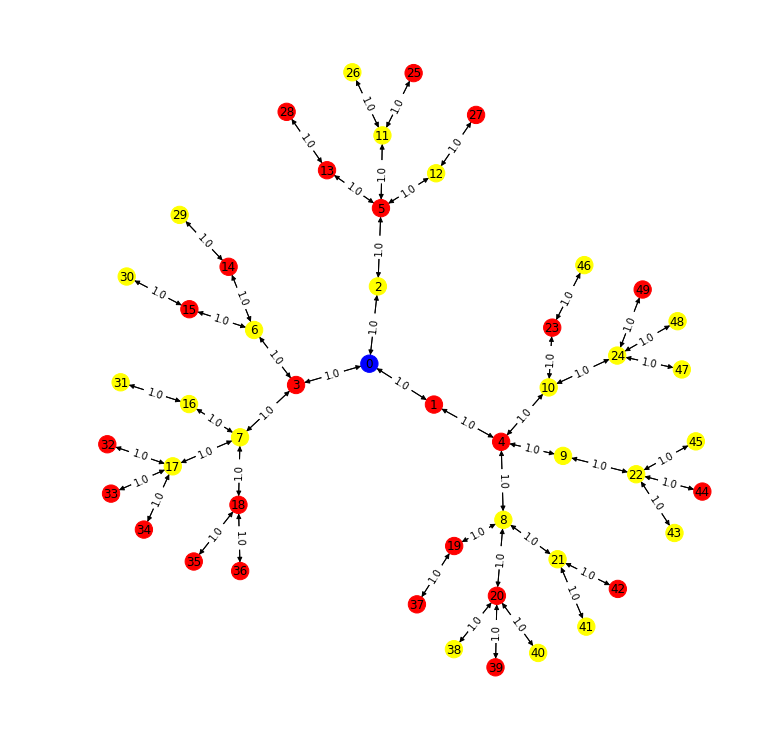

In [76]:
def draw_path(G, path):
    edges_to_draw = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edges_to_draw.append((u, v))
    plot_graph(input_path,
               layout_style=nx.kamada_kawai_layout,
               show_edge_weights=True,
               edges_to_draw=edges_to_draw,
               directed=True)

print("PATH: ", path)
draw_path(G, path)

In [ ]:
plot_graph(input_path,
           layout_style=nx.kamada_kawai_layout,
           show_edge_weights=True,
#            edges_to_draw=edges_to_draw,
           directed=True)

## Solver 2.5: Greedy

In [74]:
def greedy_shortest_path_solve(list_of_locations,
                               list_of_homes,
                               starting_car_location,
                               adjacency_matrix,
                               verbose=False,
                               params=[]):
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    source_idx = list_of_locations.index(starting_car_location)
    num_locs = len(G)
    
    home_idxs = set([list_of_locations.index(h) for h in list_of_homes])
    paths, all_pairs_dists = nx.floyd_warshall_predecessor_and_distance(G, weight='weight')
        
    def reconstruct_path(source, target, predecessors):
        if source == target:
            return []
        prev = predecessors[source]
        curr = prev[target]
        path = [target, curr]
        while curr != source:
            curr = prev[curr]
            path.append(curr)
        return list(reversed(path))
        
    traversal = [source_idx]
    
    # Find distances to previous node traversed
    dists = [
        (all_pairs_dists[traversal[-1]][h], h) for h in home_idxs
    ]
    
    while dists:
        n = min(dists, key=lambda x: x[0])
        dists.remove(n)
        n = n[1]
        traversal.extend(reconstruct_path(traversal[-1], n, paths)[1:])
        dists = [(all_pairs_dists[traversal[-1]][r], r) for _, r in dists]
        
    traversal.extend(reconstruct_path(traversal[-1], source_idx, paths)[1:])

    def assign_dropoffs(G, path, homes_idxs):
        """
        Returns the dictionary of all dropoffs along this path.
        """
        locations_on_path = set(path)
        dropoffs = collections.defaultdict(list)
        for h in homes_idxs:
            closest_loc_on_path = min(locations_on_path,
                                      key=lambda loc: all_pairs_dists[h][loc])
            dropoffs[closest_loc_on_path].append(h)
        return dropoffs
    
    return traversal, assign_dropoffs(G, traversal, home_idxs)

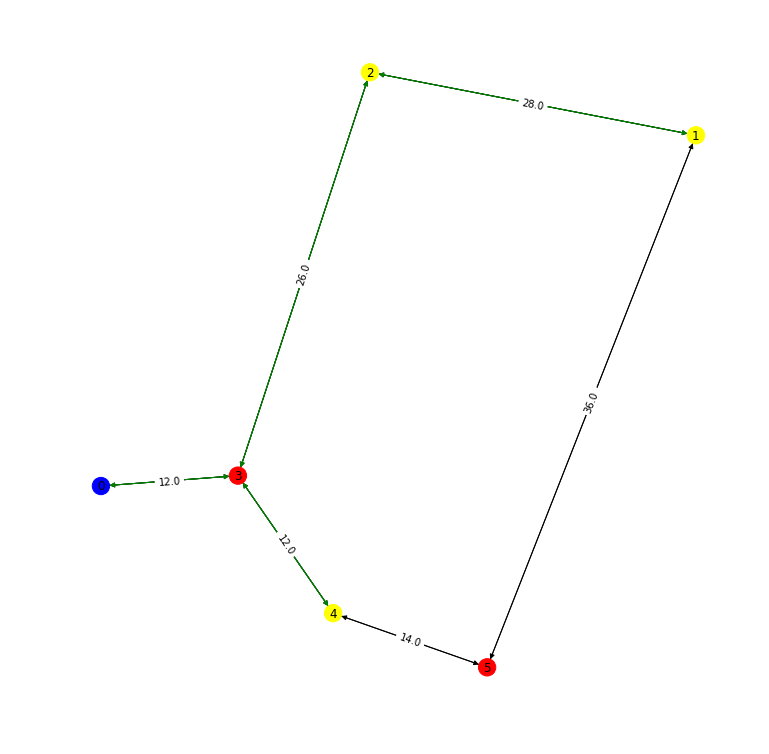

In [79]:
# input_path = '../phase1/50.in'
# input_path = './test_inputs/random_6v_3h_1.in'
# input_path = '../phase1/100.in'

(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)
G, _ = adjacency_matrix_to_graph(adj)

path, dropoffs = greedy_shortest_path_solve(location_names, house_names, source, adj)
draw_path(G, path)

## Solver 3: Local Search

Start with either a random initial solution or the solution generated by the above greedy algorithm (that still visits all houses).

Evaluate over all "neighbors" of the solution, where a neighbor is defined as a closed walk that has an alternate path between one of its vertices. (This closed walk does NOT need to go through all vertices, and it can also traverse the same edge multiple times, and it can visit a vertex multiple times.

Swap the current solution with the best of the neighbors, and continue until no neighbors are superior to the current solution.

In [ ]:
from solvers.local_search import local_search_solve

In [ ]:
# input_path = '../phase1/100.in'
# input_path = '../inputs/271_100.in'
# input_path = '../inputs/148_50.in'
input_path = '../inputs/183_100.in'
# input_path = './test_inputs/branching_20v_5h.in'
(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)
G, _ = adjacency_matrix_to_graph(adj)
path, dropoffs = local_search_solve(location_names, house_names, source, adj)

print(path)

edges_to_draw = []
for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    edges_to_draw.append((u, v))
print(edges_to_draw)
plot_graph(input_path,
           layout_style=nx.spring_layout,
           show_edge_weights=True,
           edges_to_draw=edges_to_draw,
           directed=True)

In [ ]:
G = nx.complete_graph(4)
path = [0, 1, 2, 3, 0]

def get_neighbors_alternate_paths(G, path):
    exhausted_vertices = set()
    # Track seen paths
    neighbors = set()
    for i in range(1, len(path)):
        if path[i] in exhausted_vertices:
            continue
        exhausted_vertices.add(path[i])
        
        seen_vertices = set()
        for j in range(i + 1, len(path)):
            if path[j] in seen_vertices:
                continue
            seen_vertices.add(path[j])
            
            path_so_far = path[:i]
            path_after = path[j+1:]
            print(f'path so far... {path_so_far}')
            print(f'all paths from {path[i]} to {path[j]}')
            shortest_simple_paths = k_shortest_paths(G,
                                                     source=path[i],
                                                     target=path[j],
                                                     k=2,
                                                     weight='weight')
            for alt_path in shortest_simple_paths:
#             for alt_path in nx.all_simple_paths(G, source=path[i], target=path[j], cutoff=2*(j - i)):
                if alt_path != path[i:j+1]:  # Don't want to include original as a neighbor
                    neighbors.add(tuple(path_so_far + alt_path + path_after))
                    print(alt_path, path[i:j+1])
                    break

            print(f'path after... {path_after}')
    neighbors.add((path[0], ))
    return neighbors
    
nx.draw(G, with_labels=True)
plt.show()
neighbors = get_neighbors_alternate_paths(G, path)

### Local Search experiments below

In [ ]:
def get_neighbors(G, path):
    """
    Returns "1-change" neighbors, which are all paths that:
        Either include a vertex that is not visited in path
        Include a vertex visited in path
        Swap a vertex that is visited with a vertex not visited
    """
    visited = set(path)
    unvisited = set(range(len(G))) - visited
    print(visited, unvisited)
    print(path)
    
    occurences = collections.Counter(path)
    
    neighbors = []
    
    # Exclude a vertex
    for vertex_to_exclude in visited - {0}:
        new_path = path.copy()
#         print(f'VERTEX TO EXCLUDE: {vertex_to_exclude}')

        for i in range(occurences[vertex_to_exclude]):
            idx = new_path.index(vertex_to_exclude)
            prev, nxt = new_path[idx - 1], new_path[idx + 1]
            if prev == nxt:  # Able to skip over visiting
                new_path.pop(idx)
                new_path.pop(idx)
            else:
                two_shortest = k_shortest_paths(G,
                                                source=prev,
                                                target=nxt,
                                                k=2, weight='weight')
                for alt_path in two_shortest:
                    if alt_path != path[idx-1:idx+2] and vertex_to_exclude not in alt_path:
                        new_path.pop(idx)
                        new_path = new_path[:idx-1] + alt_path + new_path[idx+1:]
                        break
            if vertex_to_exclude not in new_path:
                print(f'REMOVING {vertex_to_exclude}: {new_path}')
                neighbors.append(new_path)
    
    # Include a vertex
    for vertex_to_include in unvisited:
        new_path = path.copy()
        
        one_away = []
        for v in visited:
            if vertex_to_include in G.neighbors(v):
                one_away.append(v)
        if not one_away:
            continue
#         print(f'\nVERTEX TO INCLUDE: {vertex_to_include}')
        closest_neighbor = min(one_away, key=lambda n: G[vertex_to_include][n]['weight'])
        # Get the index of the closest neighbor, check if a path exists between 
        # the vertex being added and the next vertex in the path. If so, a better
        # detour exists than the trivial path to the new vertex and directly back.
        closest_idx = new_path.index(closest_neighbor)
        if G.has_edge(vertex_to_include, new_path[closest_idx + 1]):
            new_path.insert(closest_idx + 1, vertex_to_include)
        else:
            new_path.insert(closest_idx + 1, closest_neighbor)
            new_path.insert(closest_idx + 1, vertex_to_include)
        print(f'ADDING {vertex_to_include}: {new_path}')
        neighbors.append(new_path)
        
    # Swap a vertex (maybe add this)
        
    return neighbors

def assign_dropoffs(G, path, homes_idxs):
    """
    Returns the dictionary of all dropoffs along this path.
    """
    all_pairs_dists = nx.floyd_warshall(G, weight='weight')
#     print(all_pairs_dists)
    locations_on_path = set(path)
    dropoffs = collections.defaultdict(list)
#     print(locations_on_path)
    for h in homes_idxs:
#         print(f'DISTANCES FOR {h}', all_pairs_dists[h])
        closest_loc_on_path = min(locations_on_path, key=lambda loc: all_pairs_dists[h][loc])
        dropoffs[closest_loc_on_path].append(h)
    return dropoffs

G = nx.Graph()
G.add_weighted_edges_from([(0, 1, 1), (1, 2, 1), (0, 3, 1), (3, 4, 1), (3, 5, 2), (0, 4, 2)])
# path = [0, 1, 2, 1, 0, 3, 4, 3, 0]
print(G[4][0]['weight'])
path = [0, 1, 0, 3, 0]
home_idxs = [2, 3, 4]

# G = nx.complete_graph(4)
# path = [0, 1, 3, 0]

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
plt.show()
# get_neighbors(G, path)
assign_dropoffs(G, path, home_idxs)

In [ ]:
neighbors

In [ ]:
len(path)

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from([(0, 1, 1), (1, 2, 1), (0, 3, 1), (3, 4, 1)])
nx.draw(G, with_labels=True)
# path = [0, 1, 2, 1, 0, 3, 4, 3, 0]
# path = [0, 1, 2, 1, 0]
path = [0, 1, 0, 3, 0]
# path = [0, 1, 0]
get_neighbors(G, path)

## Solver 3.5: Simulated Annealing

In [ ]:
def simulated_annealing_solve(list_of_locations,
                               list_of_homes,
                               starting_car_location,
                               adjacency_matrix,
                               initial_solution=None,
                               verbose=False,
                               params=[]):

    start = time.time()
    # Generate initial solution (random or greedy algorithm)
    if not initial_solution:
        current_solution, _ = mst_dfs_solve(list_of_locations,
                                         list_of_homes,
                                         starting_car_location,
                                         adjacency_matrix,
                                         params=params)
    else:
        current_solution = initial_solution

    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    
    home_idxs = [list_of_locations.index(h) for h in list_of_homes]
    all_pairs_dists = nx.floyd_warshall(G, weight='weight')
    
    def get_neighbors(G, path):
        """
        Returns "1-change" neighbors, which are all paths that:
            Either include a vertex that is not visited in path
            Include a vertex visited in path
            Swap a vertex that is visited with a vertex not visited
        """
        visited = set(path)
        unvisited = set(range(len(G))) - visited

        occurences = collections.Counter(path)

        neighbors = []

        # Exclude a vertex
        for vertex_to_exclude in visited - {0}:
            new_path = path.copy()
    #         print(f'VERTEX TO EXCLUDE: {vertex_to_exclude}')

            for i in range(occurences[vertex_to_exclude]):
                idx = new_path.index(vertex_to_exclude)
                prev, nxt = new_path[idx - 1], new_path[idx + 1]
                if prev == nxt:  # Able to skip over visiting
                    new_path.pop(idx)
                    new_path.pop(idx)
                else:
                    two_shortest = k_shortest_paths(G, source=prev, target=nxt,
                                                    k=2, weight='weight')
                    for alt_path in two_shortest:
                        if alt_path != path[idx-1:idx+2] and vertex_to_exclude not in alt_path:
                            new_path.pop(idx)
                            new_path = new_path[:idx-1] + alt_path + new_path[idx+1:]
                            break
                if vertex_to_exclude not in new_path:
#                     print(f'REMOVING {vertex_to_exclude}: {new_path}')
                    neighbors.append(new_path)
        
        # Include a vertex
        for vertex_to_include in unvisited:
            new_path = path.copy()

            one_away = []
            for v in visited:
                if vertex_to_include in G.neighbors(v):
                    one_away.append(v)
            if not one_away:
                continue
    #         print(f'\nVERTEX TO INCLUDE: {vertex_to_include}')
            closest_neighbor = min(one_away, key=lambda n: G[vertex_to_include][n]['weight'])
            # Get the index of the closest neighbor, check if a path exists between 
            # the vertex being added and the next vertex in the path. If so, a better
            # detour exists than the trivial path to the new vertex and directly back.
            closest_idx = new_path.index(closest_neighbor)
            # Make sure that the closest_idx is not the last node, otherwise this would
            # go out of bounds
            if closest_idx + 1 < len(new_path) and G.has_edge(vertex_to_include, new_path[closest_idx + 1]):
                new_path.insert(closest_idx + 1, vertex_to_include)
            else:
                new_path.insert(closest_idx + 1, closest_neighbor)
                new_path.insert(closest_idx + 1, vertex_to_include)
#             print(f'ADDING {vertex_to_include}: {new_path}')
            neighbors.append(new_path)

        # Swap a vertex (maybe add this)

        return neighbors

    def assign_dropoffs(G, path, home_idxs):
        """
        Returns the dictionary of all dropoffs along this path.
        """
        locations_on_path = set(path)
        dropoffs = collections.defaultdict(list)
    #     print(locations_on_path)
        for h in home_idxs:
    #         print(f'DISTANCES FOR {h}', all_pairs_dists[h])
            closest_loc_on_path = min(locations_on_path, key=lambda loc: all_pairs_dists[h][loc])
            dropoffs[closest_loc_on_path].append(h)
        return dropoffs

    def evaluate(G, path, home_idxs, verbose=False):
        """
        Assigns optimal dropoff locations for each TA, given a path that the car
        is going to take, and calculate the total energy expended. This is the
        metric that neighbors are going to be evaluated on.
        """
        dropoffs = assign_dropoffs(G, path, home_idxs)
        cost, msg = cost_of_solution(G, path, dropoffs, shortest=all_pairs_dists)
        if verbose:
            print(msg)

        return cost
    
    current_cost = init_cost = evaluate(G, current_solution, home_idxs)
    
    T = 10  # Initialize temperature
    def delta(neighbor_cost, curr_cost, normalization_cost, scale=1):
#         print(neighbor_cost, curr_cost, normalization_cost)
        return scale * (neighbor_cost - curr_cost) / normalization_cost
    
    temp_sched_idx = 0
#     temp_schedule = [2, 8, 1, 3, 0]
    temp_schedule = [0]
    temp_step_size = -0.1  # Decrease initially
    
    num_iterations = 10000
    
    prev_solution = None
    neighbors = []
    
    deltas = []
    for i in range(num_iterations):
        start_iter = time.time()
        
        # Only update neighbors if there is a new solution
        if current_solution is not prev_solution:
            neighbors = get_neighbors(G, current_solution)

        print(f'Iteration {i} took: {time.time() - start_iter} seconds')
        
        # Choose greedily all the time once T has reached 0
        if T == 0:
            best_neighbor = min(neighbors, key=(
                lambda neighbor_sol: evaluate(G, neighbor_sol, home_idxs)))
            best_cost = evaluate(G, best_neighbor, home_idxs, verbose=False)
            if best_cost < current_cost:
                current_solution = best_neighbor
                current_cost = best_cost
            else:
                if verbose:
                    print(f'ENDED AT ITERATION {i}')
                    print(f'Local search took: {time.time() - start} seconds')
                    print(f'Local search terminated with solution (cost={current_cost}): {current_solution}')
                evaluate(G, current_solution, home_idxs, verbose=True)
                return current_solution, assign_dropoffs(G, current_solution, home_idxs), deltas
        # Otherwise, choose w.r.t temperature and delta
        else:
            rand_neighbor = neighbors[np.random.randint(len(neighbors))]
            neighbor_cost = evaluate(G, rand_neighbor, home_idxs, verbose=False)
            if neighbor_cost < current_cost:
                current_cost = neighbor_cost
                prev_solution = current_solution
                current_solution = rand_neighbor
                if verbose:
                    print('PICKED A BETTER SOLUTION')
            else:  # Neighbor solution is worse
                delt = delta(neighbor_cost, current_cost, init_cost, scale=500)
#                 deltas.append(delt)
                
#                 print(delt)
                prob = np.exp(-delt / T)
                if np.random.rand() < prob:
                    current_cost = neighbor_cost
                    prev_solution = current_solution
                    current_solution = rand_neighbor
                    if verbose:
                        print(f'PICKED WORSE SOLUTION WITH PROBABILITY {prob}')
        
        if temp_sched_idx < len(temp_schedule):
            target = temp_schedule[temp_sched_idx]
            # Flip sign of step size when reaching the target
            if temp_step_size < 0 and T <= target:
                temp_step_size *= -1
                temp_sched_idx += 1
                print(f'TEMPERATURE REACHED {T}, STEP SIZE NOW {temp_step_size}')
            elif temp_step_size > 0 and T >= target:
                temp_step_size *= -1
                temp_sched_idx += 1
                print(f'TEMPERATURE REACHED {T}, STEP SIZE NOW {temp_step_size}')
            
            if temp_sched_idx < len(temp_schedule):
                T += temp_step_size
                T = max(0, T)  # Never want it to be negative


In [ ]:
# input_path = '../phase1/50.in'
# input_path = '../phase1/100.in'
# input_path = '../inputs/271_100.in'
# input_path = '../inputs/148_50.in'
# input_path = '../inputs/183_100.in'
# input_path = './test_inputs/branching_20v_5h.in'
input_path = './test_inputs/random_6v_3h_1.in'
(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)
G, _ = adjacency_matrix_to_graph(adj)
# path, dropoffs, deltas = simulated_annealing_solve(location_names, house_names, source, adj, verbose=True)

# edges_to_draw = []
# for i in range(len(path) - 1):
#     u, v = path[i], path[i + 1]
#     edges_to_draw.append((u, v))
# print(edges_to_draw)
# plot_graph(input_path,
#            layout_style=nx.spring_layout,
#            show_edge_weights=True,
#            edges_to_draw=edges_to_draw,
#            directed=True)

path, dropoffs = local_search_solve(location_names, house_names, source, adj)
path, dropoffs = local_search_solve(location_names, house_names, source, adj, initial_solver=dijkstra_greedy_solve)

edges_to_draw = []
for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    edges_to_draw.append((u, v))
print(edges_to_draw)
plot_graph(input_path,
           layout_style=nx.spring_layout,
           show_edge_weights=True,
           edges_to_draw=edges_to_draw,
           directed=True)

In [ ]:
binwidth = 0.01
plt.hist(deltas, bins=np.arange(min(deltas), 2, binwidth))

In [ ]:
def random_closed_walk(G, source, length):
    visited = set([source])
    path = [source]
    for i in range(length):
        
        

## Solver 4: Clustering

In [65]:
# Choose cluster points 
def k_means_solve(list_of_locations,
                  list_of_homes,
                  starting_car_location,
                  adjacency_matrix,
                  verbose=False,
                  params=[]):
    
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    num_locs = len(G)
    home_idxs = set([list_of_locations.index(h) for h in list_of_homes])
    all_pairs_dists = nx.floyd_warshall(G, weight='weight')
    source_idx = list_of_locations.index(starting_car_location)
    
    def distance_to_homes(G, center, homes):
        return sum([all_pairs_dists[center][home] for home in homes])
    
    def assign_dropoffs(G, path, home_idxs):
        """
        Returns the dictionary of all dropoffs along this path.
        """
        locations_on_path = set(path)
        dropoffs = collections.defaultdict(list)
        for h in home_idxs:
            closest_loc_on_path = min(locations_on_path, key=lambda loc: all_pairs_dists[h][loc])
            dropoffs[closest_loc_on_path].append(h)
        return dropoffs
    
    def evaluate(G, path, home_idxs, verbose=False):
        """
        Assigns optimal dropoff locations for each TA, given a path that the car
        is going to take, and calculate the total energy expended. This is the
        metric that neighbors are going to be evaluated on.
        """
        dropoffs = assign_dropoffs(G, path, home_idxs)
        cost, msg = cost_of_solution(G, path, dropoffs, shortest=all_pairs_dists)
        if verbose:
            print(msg)
        return cost
    
    solutions = []
    for num_clusters in range(1, len(list_of_homes) + 1):
        loc_list = list(range(num_locs))
        
        # Initialize centers by picking randomly first, then pick farthest vertex
        # repeatedly until list of centers is filled.
        centers = [np.random.choice(num_locs)]
        while len(centers) < num_clusters:
            farthest_center = max(loc_list, key=(
                lambda loc: sum([all_pairs_dists[loc][center] for center in centers])))
            centers.append(farthest_center)
#         print(centers)

        # Randomly initialize centers (without replacement for `num_clusters` distinct locations)
    #     centers = list(np.random.choice(num_locs, size=num_clusters, replace=False))
    
        while True:
            clusters = collections.defaultdict(list)
            for loc in range(num_locs):
                closest_center = min(centers, key=lambda center: all_pairs_dists[loc][center])
                clusters[closest_center].append(loc)
    #         print(clusters)

            new_centers = []
            for center in centers:
                homes_in_cluster = set([
                    home for home in clusters[center] if home in home_idxs
                ])
                new_center = center
                min_cost = distance_to_homes(G, center, homes_in_cluster)
                for candidate in clusters[center]:
                    candidate_cost = distance_to_homes(G, candidate, homes_in_cluster)
                    if candidate_cost < min_cost:
                        new_center = candidate
                        min_cost = candidate_cost
                new_centers.append(new_center)
            if centers == new_centers:
                break
            centers = new_centers

#         plt.figure(figsize=(10,10))
#         pos = nx.kamada_kawai_layout(G)
#         colors = ['red', 'green', 'orange', 'purple', 'blue', 'yellow']
#         colormap = [
#             colors[centers.index(min(centers, key=lambda center: all_pairs_dists[loc][center]))]
#             for loc in loc_list
#         ]
#         nx.draw(G, pos=pos, node_color=colormap, with_labels=True)
#         labels = nx.get_edge_attributes(G, 'weight')
#         nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)

        # Find partial MST, then do 2-approx TSP on this
        mst = nx.minimum_spanning_tree(G)
        partial_mst_vertices = set()
        for i in range(len(centers)):
            c1 = centers[i]
            for j in range(i, len(centers)):
                c2 = centers[j]
                path = nx.shortest_path(mst, source=c1, target=c2, weight='weight')
                partial_mst_vertices.update(path)
        unused_vertices = set(loc_list) - partial_mst_vertices
        
        closest_in_mst = min(
            partial_mst_vertices, key=lambda mst_node: all_pairs_dists[mst_node][source_idx])
        source_to_mst_path = set(nx.shortest_path(G, source=source_idx, target=closest_in_mst, weight='weight'))

        unused_vertices = unused_vertices - source_to_mst_path
        print(source_to_mst_path)
        for v in unused_vertices:
            mst.remove_node(v)

        print('MST NODES:', mst.nodes())
        print('MST EDGES:', mst.edges())

#         plot_graph(input_path,
#                    layout_style=nx.kamada_kawai_layout,
#                    show_edge_weights=False,
#                    edges_to_draw=mst.edges(),
#                    directed=True)
    
        solution, _ = mst_dfs_solve(list_of_locations,
                                    list_of_homes,
                                    starting_car_location,
                                    adjacency_matrix,
                                    existing_mst=mst)
        print(solution)
        solutions.append(solution)
    
    costs = [evaluate(G, sol, home_idxs) for sol in solutions]
    best_idx = np.argmin(costs)  # Also equal to optimal # of clusters - 1
    best_solution = solutions[best_idx]
    print(f'BEST SOLUTION WITH {best_idx + 1} CLUSTERS, COST={costs[best_idx]}: ', best_solution)
    
#     def draw_path(G, path):
#         edges_to_draw = []
#         for i in range(len(path) - 1):
#             u, v = path[i], path[i + 1]
#             edges_to_draw.append((u, v))
#         plot_graph(input_path,
#                    layout_style=nx.kamada_kawai_layout,
#                    show_edge_weights=True,
#                    edges_to_draw=edges_to_draw,
#                    directed=True)
#     draw_path(G, best_solution)
    
    return best_solution, assign_dropoffs(G, best_solution, home_idxs)

In [ ]:
# input_path = '../phase1/50.in'
# input_path = './test_inputs/random_6v_3h_1.in'
# input_path = '../phase1/100.in'
input_path = '../phase1/200.in'

(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)
G, _ = adjacency_matrix_to_graph(adj)

path, _ = k_means_solve(location_names, house_names, source, adj)
path, dropoffs = local_search_solve(location_names, house_names, source, adj, initial_solution=path)
path, dropoffs = local_search_solve(location_names, house_names, source, adj)

In [ ]:
path